## Baby names classification : Method with pretrained LLMs
by Jad El Karchi

### Import libraries

In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

/home/jelkarchi/.homenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Dataframe

In [2]:
# load the dataset
names_df = pd.read_csv('babynames-clean.csv', header=None)
names_df.columns = ["name", "gender"]
names_df

,name,gender
0,John,boy
1,William,boy
2,James,boy
3,Charles,boy
4,George,boy
...,...,...
6777,Laylah,girl
6778,Carleigh,girl
6779,Kenley,girl
6780,Sloane,girl


# Statistics

<Axes: xlabel='gender', ylabel='count'>

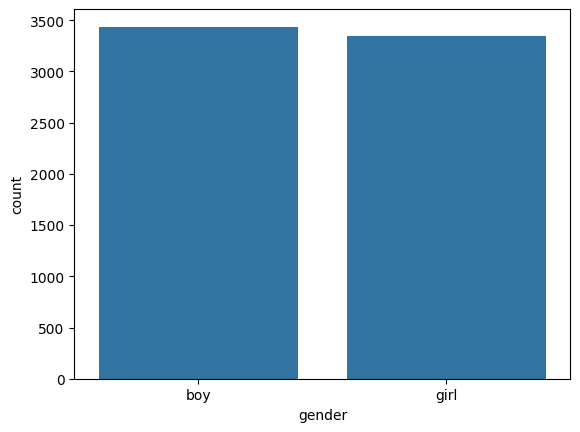

In [3]:
# amount of boy/girl names in the database
sns.barplot(x=names_df["gender"].value_counts().index, y=names_df["gender"].value_counts())

In [ ]:
# verifiying that there are no missing values in the dataframe and that only two genders are in the dataframe
assert names_df["name"].isna().sum() == 0
assert names_df["gender"].isna().sum() == 0

assert names_df["name"].nunique() == 6782
assert names_df["gender"].nunique() == 2

## Loading BERT Model

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/home/jelkarchi/.homenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Tokenizing and Vectorizing names

In [6]:
def tokenize_names(names):
    return tokenizer(names, padding=True, truncation=True, return_tensors='pt')

# Tokenize names
tokenized_names = tokenize_names(names_df['name'].tolist())

# get embeddings for each name
with torch.no_grad():
    outputs = model(**tokenized_names)
embeddings = outputs.last_hidden_state[:, 0, :].numpy() 


# encode gender labels to have 0/1 instead of boy/girl labels
label_encoder = LabelEncoder()
names_df['gender_label'] = label_encoder.fit_transform(names_df['gender'])

## Train a Classifier Model

In [7]:
# split the database, 80% for training and 20% of testing
X_train, X_test, y_train, y_test = train_test_split(embeddings, names_df['gender_label'], test_size=0.2, random_state=42)

classifier = RandomForestClassifier()
# Train our classifier on embeddings
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1 score: {f1 * 100:.2f}%")

Accuracy: 84.38%
F1 score: 83.17%


# Improvement points
- Use XGBoost based classifier
- Use Kfold training/testing selection
- Use Hyperparameters for score improvemment